In [ ]:
%matplotlib inline


# Training using REINFORCE

## Introduction: Lunar Lander

The environment's idea is to land the rocket on the land, inside the landing zone, and without crashing.

Observations (8):
- X position of the rocket.
- Y position of the rocket.
- X velocity.
- Y velocity.
- Angle of the rocket.
- Angular velocity of the rocket.
- Left leg in contact with the land.
- Right leg in contact with the land.

Actions (4):
- Do nothing
- Fire left engine.
- Fire main engine.
- Fire right engine.

Rewards:
- -100 when the rocket crashes.
- +100 when it comes to rest.
- +10 for each leg contacting the ground.
- -0.3 for firing the main engine.
- -0.03 for firing the side engines.

An episode with a return of >= 200 is considered as solved.


In [ ]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]

import gymnasium as gym

print(f"OpenAI Gym version: {gym.__version__}")
print(f'PyTorch version {torch.__version__}')

plt.rcParams["figure.figsize"] = (10, 5)

  Using cached swig-4.1.1.post0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373127 sha256=3a6f2f40f7b3cad04473a713364d766488fa9bde61917b521f06fabcb817d688
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
OpenAI Gym version: 0.29.1
PyTorch version 2.1.0+cu118


### Helpers

In [ ]:
# Video management imports
import cv2

# Helper functions to save videos and images
def save_video(img_array, path='./video/test.mp4'):
  height, width, layers = img_array[0].shape
  size = (width, height)
  out = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*'AVC1'), 15, size)
  for i in range(len(img_array)):
    bgr_img = cv2.cvtColor(img_array[i], cv2.COLOR_RGB2BGR)
    out.write(bgr_img)
  out.release()
  print('Video saved.')

def save_images(img_array, path='./images'):
  for i, image in enumerate(img_array):
    bgr_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path + '/img_' + str(i) + '.jpg', bgr_img)

## Loss Function

The loss function for the REINFORCE method is

$$ \mathcal{L}(\theta_{t}) = \mathbb{E}_{\pi}[G_t \log \pi(A_t | S_t, \theta_t)] $$

where $G_t$ is the expected reward, that we compute from experience and $\pi(A_t | S_t, \theta_t)$ is the policy we get from the DNN, i.e., the probability distribution over actions.

And the update is done in gradient *ascent* style

$$ \theta_{t+1} = \theta_t + \alpha \triangledown \mathcal{L}(\theta_{t}) $$

The loss gradient is used to update the parameters, $\theta$, during the backward propagation of the DNN, so we don't do this step manually.

Note: As SGD and Adam optimizers follow a gradient *descent* method, we add a minus sign to the loss function.



In [ ]:
class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes a neural network that estimates the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """
        super().__init__()

        hidden_space1 = 16  # Nothing special with 16, feel free to change
        hidden_space2 = 32  # Nothing special with 32, feel free to change

        # Shared Network
        self.net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
            nn.Linear(hidden_space2, action_space_dims)
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Conditioned on the observation, returns the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            x: Observation from the environment

        Returns:
            action_means: predicted mean of the normal distribution
            action_stddevs: predicted standard deviation of the normal distribution
        """
        action_logits = self.net(x.float())

        return action_logits

## Building an agent

<img src="imgs/reinforce_invpend_gym_v26_fig3.jpeg">

Now that we are done building the policy, let us develop **REINFORCE** which gives life to the policy network.
The algorithm of REINFORCE could be found above. As mentioned before, REINFORCE aims to maximize the Monte-Carlo returns.

Fun Fact: REINFROCE is an acronym for " 'RE'ward 'I'ncrement 'N'on-negative 'F'actor times 'O'ffset 'R'einforcement times 'C'haracteristic 'E'ligibility

Note: The choice of hyperparameters is to train a decently performing agent. No extensive hyperparameter
tuning was done.




In [ ]:
class REINFORCE:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes an agent that learns a policy via REINFORCE algorithm [1]
        to solve the task at hand (Inverted Pendulum v4).

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 1e-4  # Learning rate for policy optimization
        self.gamma = 0.99  # Discount factor
        self.eps = 1e-6  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def select_action(self, state: np.ndarray) -> torch.Tensor:
        """Returns an action, conditioned on the policy and observation.

        Args:
            state: Observation from the environment

        Returns:
            action: Action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_logits = self.net(state)

        # create a normal distribution from the predicted
        #   mean and standard deviation and sample an action
        distrib = torch.distributions.Categorical(logits=action_logits)  # implicitly uses softmax
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []

Now lets train the policy using REINFORCE to master the task of Inverted Pendulum.

Following is the overview of the training procedure

>    for seed in random seeds
>       reinitialize agent
>
>       for episode in range of max number of episodes
>           until episode is done
>               sample action based on current observation
>
>               take action and receive reward and next observation
>
>               store action take, its probability, and the observed reward
>           update the policy


In [ ]:
# Total number of episodes
total_num_episodes = 5_000
ENV_NAME = 'LunarLander-v2'

In [ ]:
# Create and wrap the environment
env = gym.make('LunarLander-v2', render_mode='rgb_array')
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

# Observation-space of LunarLander-v2 (8)
obs_space_dims = env.observation_space.shape[0]

# Action-space of InvertedPendulum-v4 (4)
action_space_dims = env.action_space.n

seed = 1

# set seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Reinitialize agent every seed
agent = REINFORCE(obs_space_dims, action_space_dims)
reward_over_episodes = []

for episode in tqdm(range(total_num_episodes)):
    # gymnasium v26 requires users to set seed while resetting the environment
    obs, info = wrapped_env.reset(seed=seed)

    done = False
    while not done:
        action = agent.select_action(obs)

        # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
        # These represent the next observation, the reward from the step,
        # if the episode is terminated, if the episode is truncated and
        # additional info from the step
        obs, reward, terminated, truncated, info = wrapped_env.step(action[0])
        agent.rewards.append(reward)

        # End the episode when either truncated or terminated is true
        #  - truncated: The episode duration reaches max number of timesteps
        #  - terminated: Any of the state space values is no longer finite.
        done = terminated or truncated

    reward_over_episodes.append(wrapped_env.return_queue[-1])
    agent.update()


  0%|          | 0/5000 [00:00<?, ?it/s]

## Plot learning curve




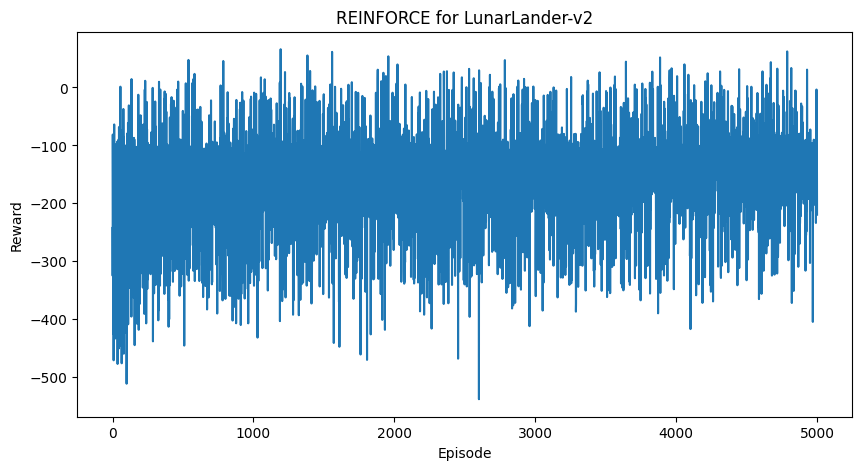

In [ ]:
rewards_to_plot = [reward[0] for reward in reward_over_episodes]
x = np.arange(len(rewards_to_plot))
# Plot the values
plt.plot(x, rewards_to_plot)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('REINFORCE for LunarLander-v2')
plt.show()

## Test the agent

In [ ]:
done = False

img_array=[]

wrapped_env.reset()

while not done:
    with torch.no_grad():
        action = agent.select_action(obs)

    obs, reward, terminated, truncated, info = wrapped_env.step(action[0])
    frame = wrapped_env.render()
    img_array.append(frame)

    done = terminated or truncated

save_video(img_array, './video/REINFORCE_lunar_lander.mp4')

Video saved.


In [ ]:
from IPython.display import Video
Video('./video/REINFORCE_lunar_lander.mp4', embed=True)


## Notes

Deep RL is fairly brittle concerning random seed in a lot of common use cases (https://spinningup.openai.com/en/latest/spinningup/spinningup.html).







## The agent is not learning. If it were, we would see an increase in the reward over time. Although the reward is not completely random, averaging around 200, it should be steadily increasing as learning progresses. However, the reward remains stagnant, indicating a lack of improvement.


## References

[1] Williams, Ronald J.. “Simple statistical gradient-following
algorithms for connectionist reinforcement learning.” Machine Learning 8
(2004): 229-256.
